In [1]:
import requests
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.offsetbox import  OffsetImage

In [2]:
def retrive_data(player_id,nba_season):
    # url = "https://stats.nba.com/stats/shotchartdetail?AheadBehind=&CFID=33&CFPARAMS="+ b +"&ClutchTime=&Conference=&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&Division=&EndPeriod=10&EndRange=28800&GROUP_ID=&GameEventID=&GameID=&GameSegment=&GroupID=&GroupMode=&GroupQuantity=5&LastNGames=0&LeagueID=00&Location=&Month=0&OnOff=&OpponentTeamID=0&Outcome=&PORound=0&Period=0&PlayerID="+ a +"&PlayerID1=&PlayerID2=&PlayerID3=&PlayerID4=&PlayerID5=&PlayerPosition=&PointDiff=&Position=&RangeType=0&RookieYear=&Season="+ b +"&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StartPeriod=1&StartRange=0&StarterBench=&TeamID=0&VsConference=&VsDivision=&VsPlayerID1=&VsPlayerID2=&VsPlayerID3=&VsPlayerID4=&VsPlayerID5=&VsTeamID="
    url_base = 'https://stats.nba.com/stats/shotchartdetail'
    parameters = {
        'ContextMeasure': 'FGA',
        'LastNGames': 0,
        'LeagueID': '00',
        'Month': 0,
        'OpponentTeamID': 0,
        'Period': 0,
        'PlayerID': player_id,
        'SeasonType': 'Regular Season',
        'TeamID': 0,
        'VsDivision': '',
        'VsConference': '',
        'SeasonSegment': '',
        'Season': nba_season,
        'RookieYear': '',
        'PlayerPosition': '',
        'Outcome': '',
        'Location': '',
        'GameSegment': '',
        'GameId': '',
        'DateTo': '',
        'DateFrom': ''
    }

    headers = {
        'Host': 'stats.nba.com',
        'Connection': 'keep-alive',
        'Accept': 'application/json, text/plain, */*',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
        'Referer': 'https://stats.nba.com/',
        "x-nba-stats-origin": "stats",
        "x-nba-stats-token": "true",
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
    }

    response = requests.get(url_base, params=parameters, headers=headers)
    data = response.json()
    return data

In [3]:
def create_court(ax=None,color='black',lw=2):
    if ax is None:
        ax = plt.gca()
    
    hoop = Circle((0,0), radius =7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80,-47.5),160,190,linewidth=lw, color=color,fill=False)
    inner_box = Rectangle((-60, -47.5), 120,190, linewidth=lw, color=color,fill=False)
    top_free_throw = Arc((0,142.5), 120,120,theta1=0,theta2=180,linewidth=lw, color=color)
    bottom_free_throw = Arc((0,142.5), 120,120,theta1=180,theta2=0,linewidth=lw, color=color, linestyle='dashed')
    restricted_area = Arc((0,0), 80,80,theta1=0,theta2=180,linewidth=lw,color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,color=color)
    
    court_elements = [hoop,backboard,outer_box,inner_box,top_free_throw,bottom_free_throw,restricted_area,corner_three_a,corner_three_b,three_arc]
    
    for element in court_elements:
        ax.add_patch(element)
        
    return ax

In [4]:
def get_miss_and_made(data):
    headers = data['resultSets'][0]['headers']
    game_stat = data['resultSets'][0]['rowSet']
    game_stat_df = pd.DataFrame(game_stat, columns=headers)
    made = game_stat_df[game_stat_df['SHOT_MADE_FLAG']==1]
    miss = game_stat_df[game_stat_df['SHOT_MADE_FLAG']==0]
    return made,miss,game_stat_df

In [5]:
def get_pic(player_id):
    pic = urllib.request.urlretrieve("http://stats.nba.com/media/players/230x185/"+player_id+".png",
                                    player_id+".png")
    player_pic = plt.imread(pic[0])
    return player_pic

In [6]:
def get_shot_chart(made,miss,game_stat_df,player_pic):
    plt.figure(figsize=(12,11))
    plt.ylim(400,-47.5)
    plt.xlim(-250,250)
    plt.scatter(miss.LOC_X,miss.LOC_Y,c='r',marker='.',alpha=0.3,label='miss')
    plt.scatter(made.LOC_X,made.LOC_Y,c='g',marker='.',alpha=0.3,label='made')
    plt.tick_params(labelbottom=False, labelleft=False)
    create_court()
    name = game_stat_df.iloc[0]['PLAYER_NAME']
    plt.title(name+' '+nba_season)
    img = OffsetImage(player_pic, zoom=0.6)
    img.set_offset((540,55))
    plt.gca().add_artist(img)
    plt.legend()
    plt.show()

In [7]:
def get_heat_map(game_stat_df,player_pic):
    cmap=plt.cm.YlOrRd_r
    plot = sns.jointplot(x = game_stat_df.LOC_X,y=game_stat_df.LOC_Y,kind='kde',stat_func=None,color=cmap(0.3),cmap=cmap,n_levels =50)
    plot.fig.set_size_inches(12,10)
    ax = plot.ax_joint
    ax.set_ylim(400,-47.5)
    ax.set_xlim(-250,250)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')
    create_court(ax)
    name = game_stat_df.iloc[0]['PLAYER_NAME']
    ax.set_title(name+' '+nba_season)
    img = OffsetImage(player_pic, zoom=0.5)
    img.set_offset((650,550))
    ax.add_artist(img)
    plt.show()

### James Harden 2018-19

In [8]:
player_id = input("please input the player's ID: ") # can be found at NBA official site
nba_season = input("please input the NBA season: ")

please input the player's ID: 201935
please input the NBA season: 2018-19


In [9]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

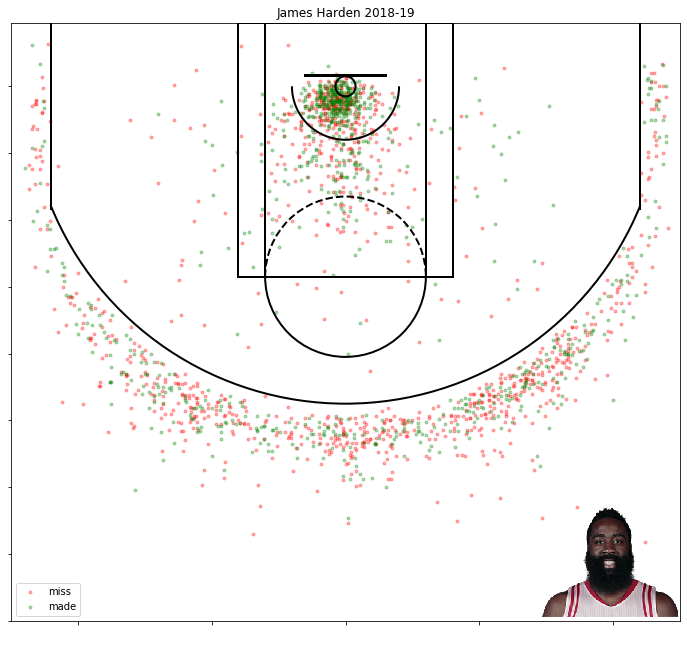

In [10]:
get_shot_chart(made,miss,game_stat_df,player_pic)

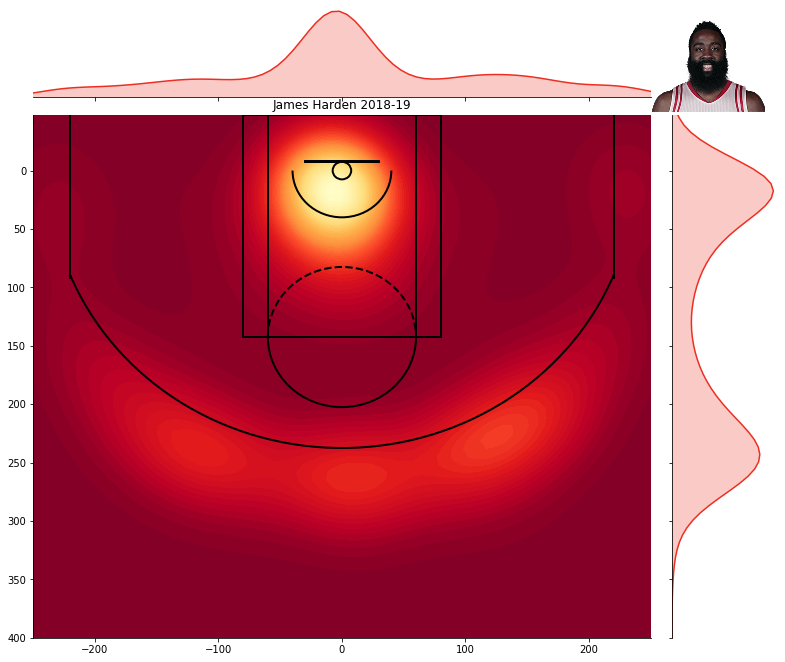

In [11]:
get_heat_map(game_stat_df,player_pic)

### Stephen Curry 2018-19

In [12]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 201939
please input the NBA season: 2018-19


In [13]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

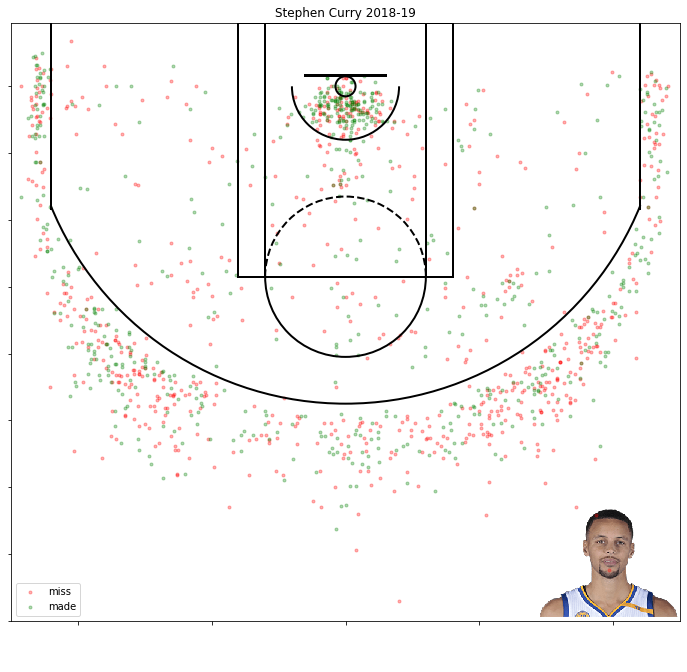

In [14]:
get_shot_chart(made,miss,game_stat_df,player_pic)

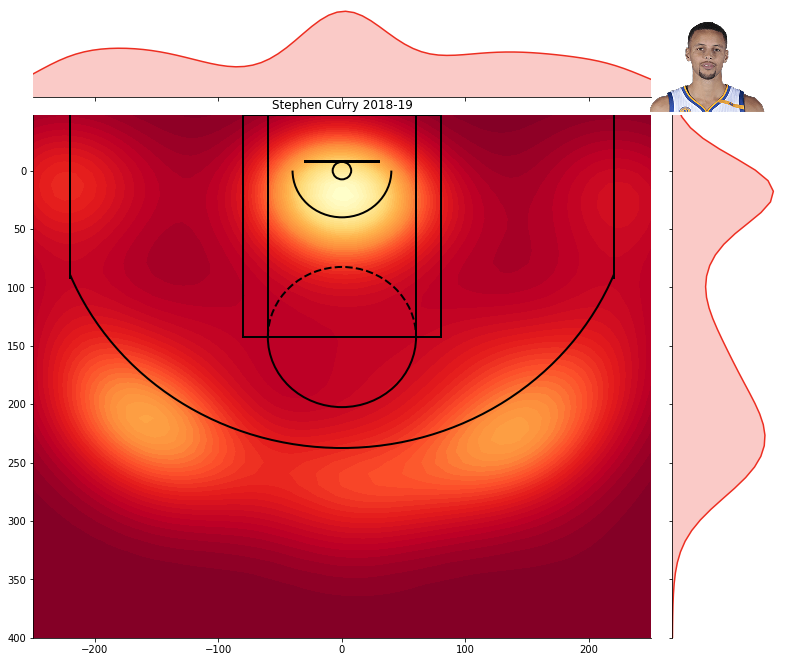

In [15]:
get_heat_map(game_stat_df,player_pic)

### Kevin Durant 2018-19

In [16]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 201142
please input the NBA season: 2018-19


In [17]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

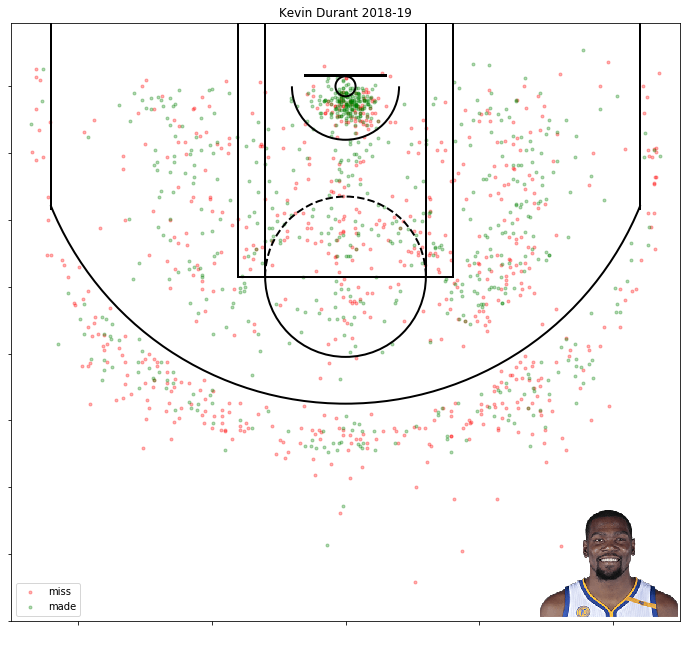

In [18]:
get_shot_chart(made,miss,game_stat_df,player_pic)

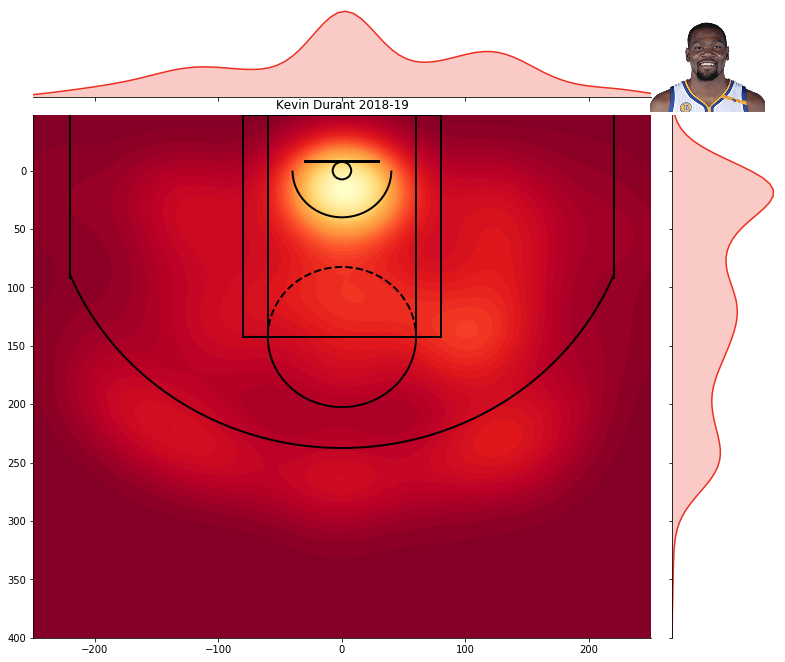

In [19]:
get_heat_map(game_stat_df,player_pic)

### Klay Thompson 2018-19

In [20]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 202691
please input the NBA season: 2018-19


In [21]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

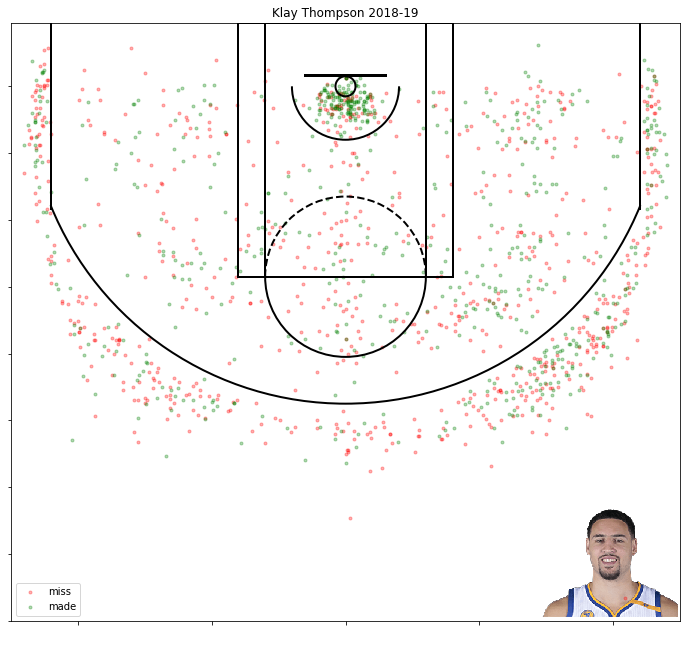

In [22]:
get_shot_chart(made,miss,game_stat_df,player_pic)

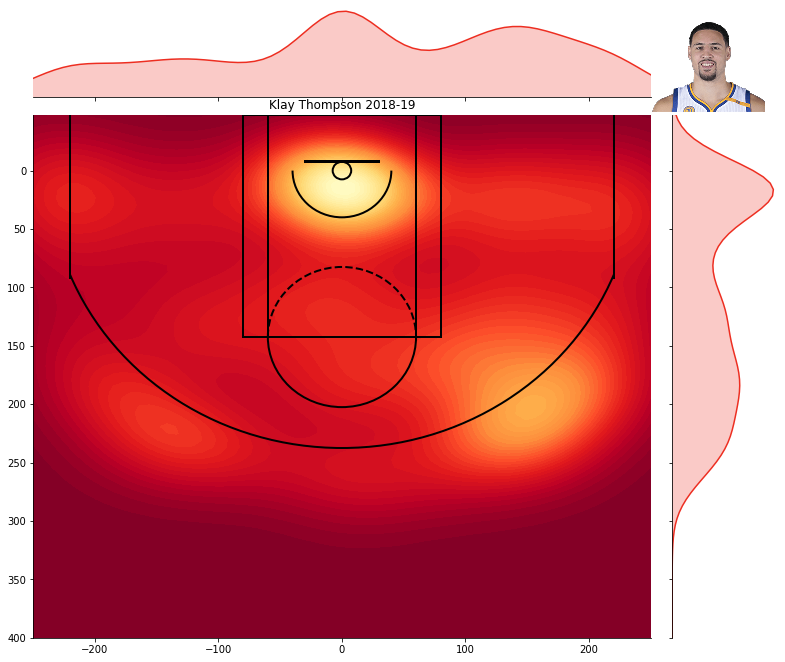

In [23]:
get_heat_map(game_stat_df,player_pic)

### Giannis Antetokounmpo 2018-19

In [24]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 203507
please input the NBA season: 2018-19


In [25]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

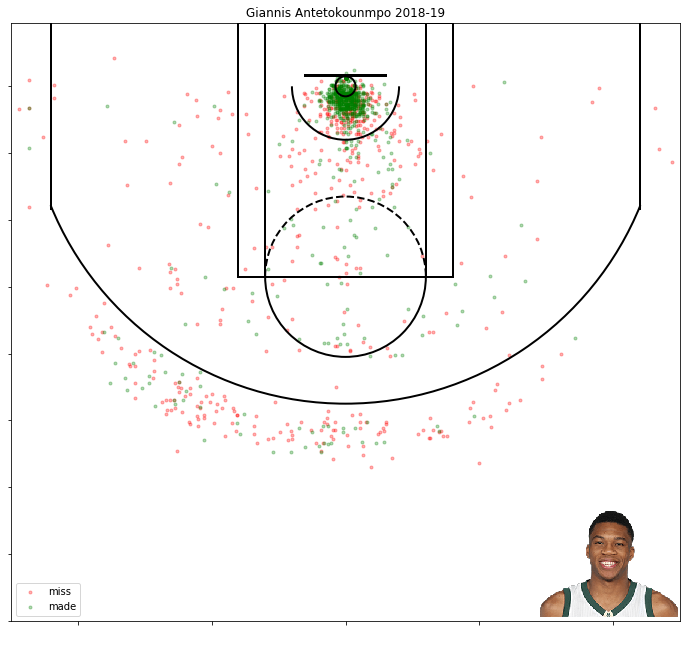

In [26]:
get_shot_chart(made,miss,game_stat_df,player_pic)

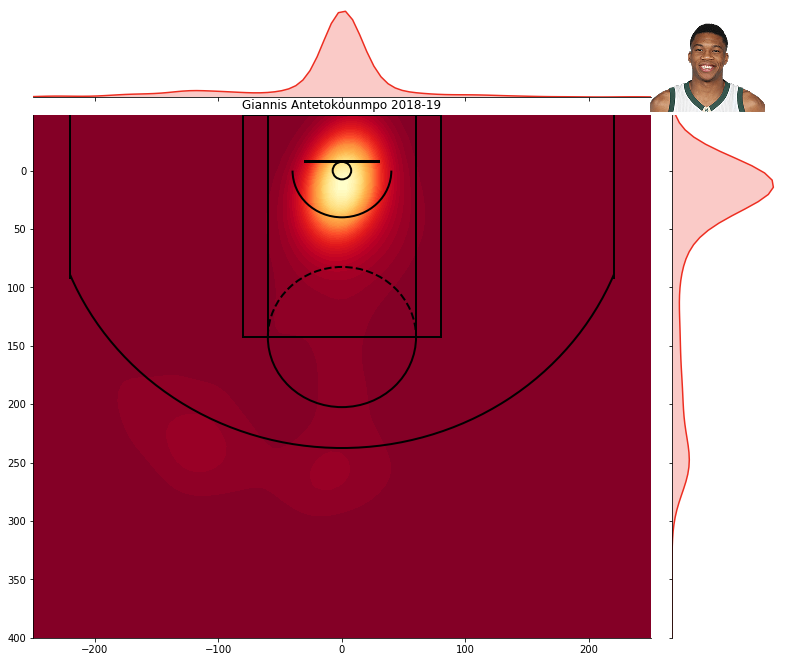

In [27]:
get_heat_map(game_stat_df,player_pic)

### Nikola Jokic 2018-19

In [28]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 203999
please input the NBA season: 2018-19


In [29]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

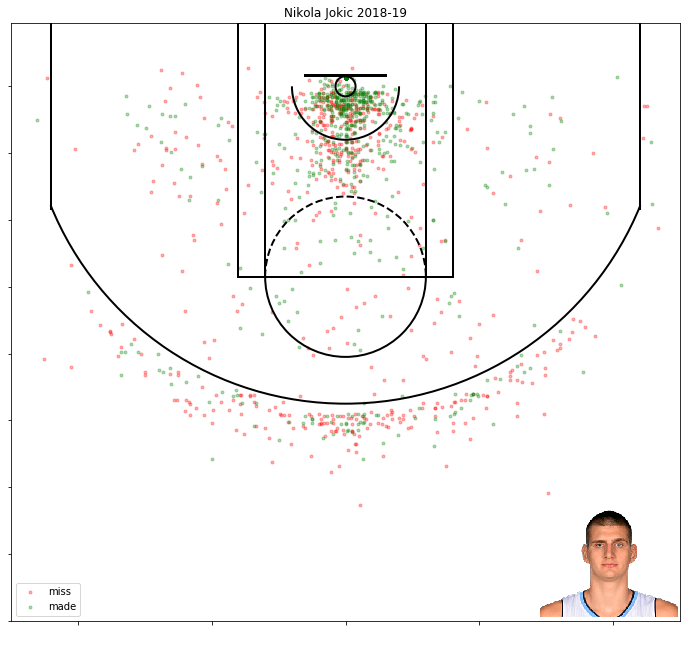

In [30]:
get_shot_chart(made,miss,game_stat_df,player_pic)

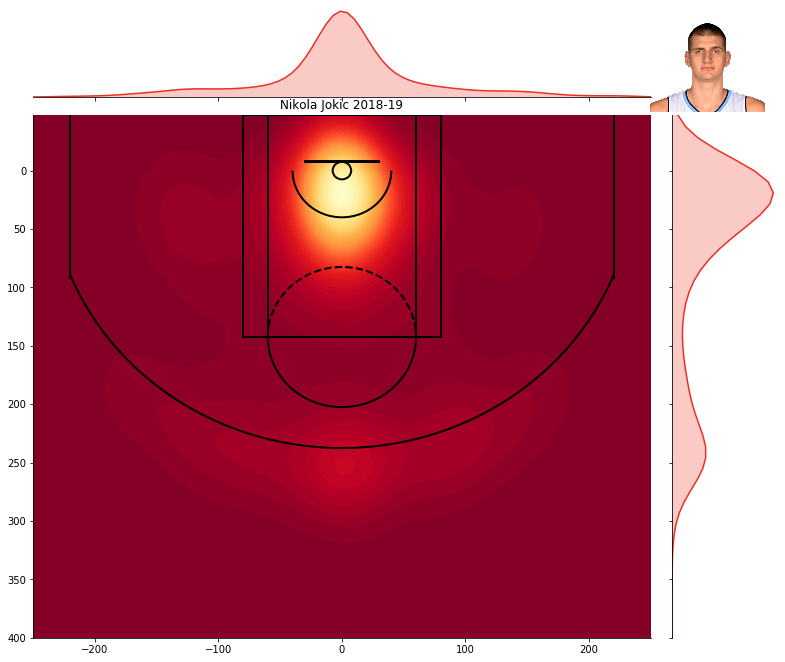

In [31]:
get_heat_map(game_stat_df,player_pic)

### LeBron James 2018-19

In [32]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 2544
please input the NBA season: 2018-19


In [34]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

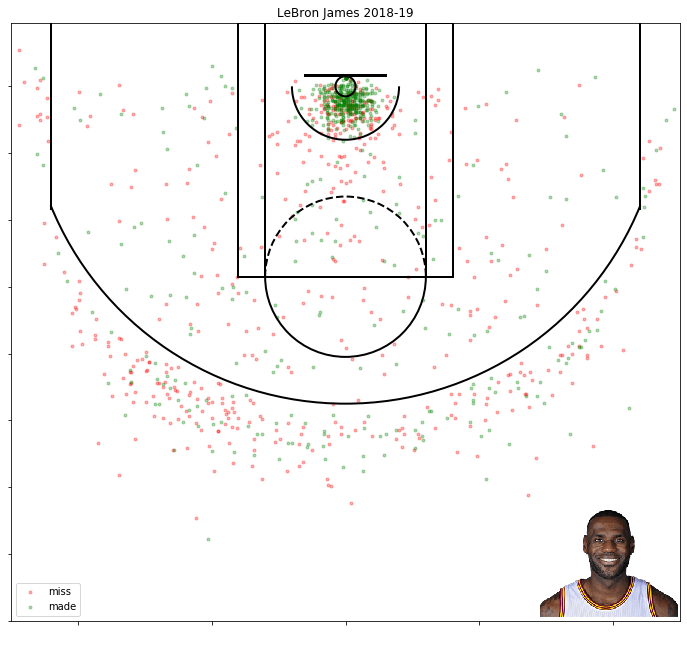

In [35]:
get_shot_chart(made,miss,game_stat_df,player_pic)

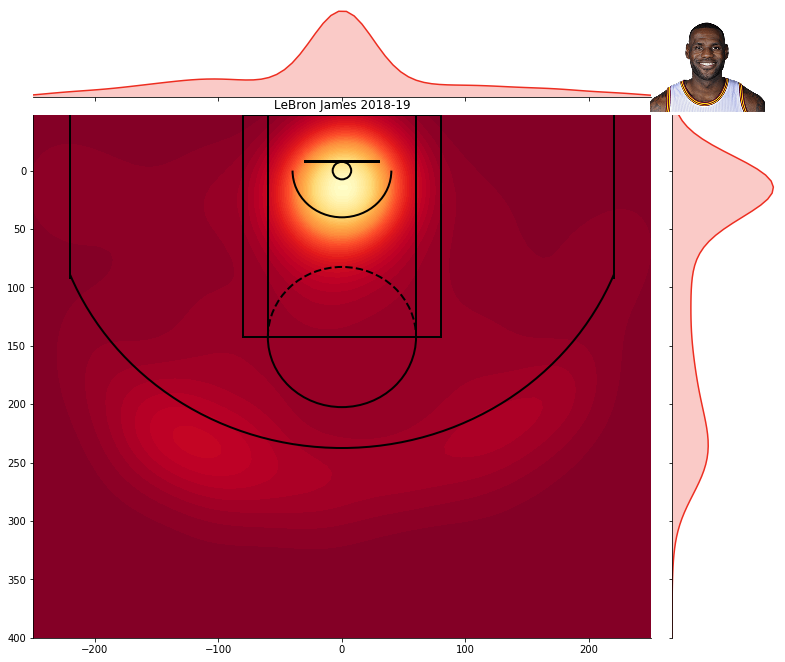

In [36]:
get_heat_map(game_stat_df,player_pic)

### Ben Simmons 2018-19

In [37]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 1627732
please input the NBA season: 2018-19


In [38]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

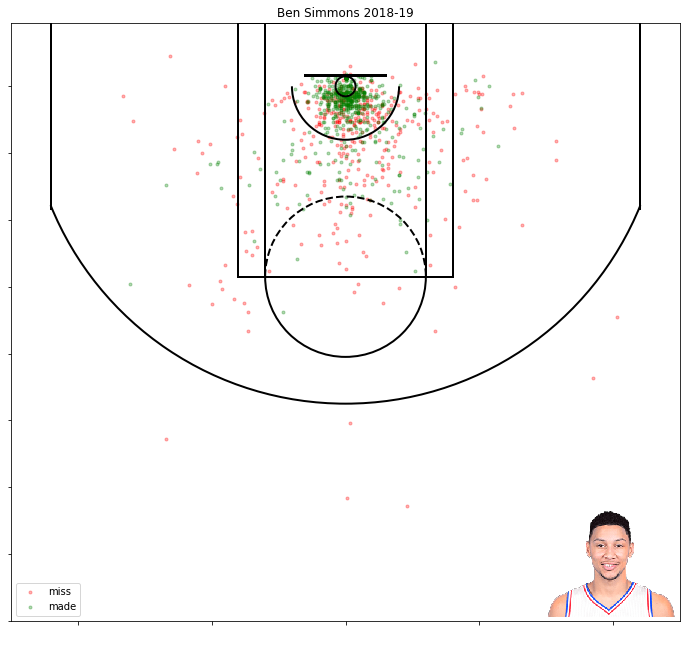

In [39]:
get_shot_chart(made,miss,game_stat_df,player_pic)

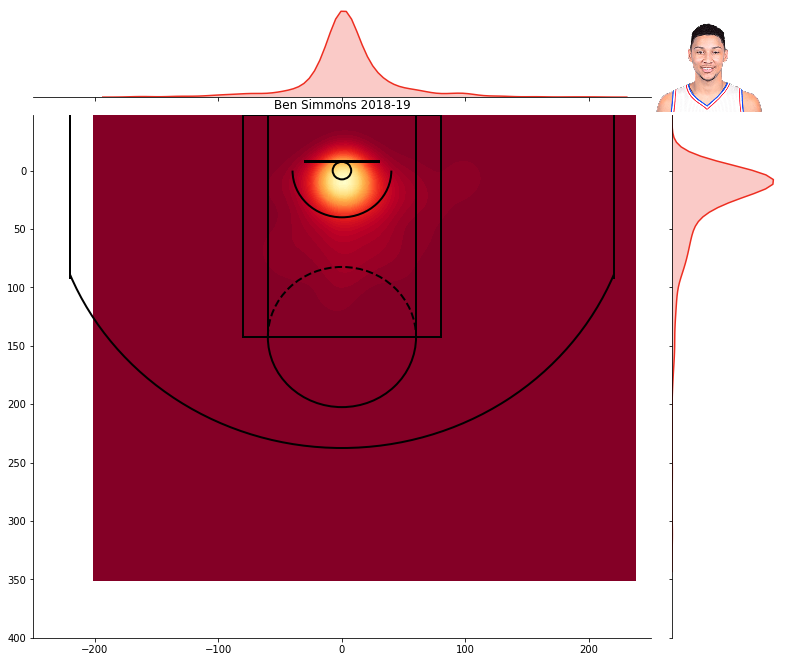

In [40]:
get_heat_map(game_stat_df,player_pic)

### Kawhi Leonard 2018-19

In [41]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 202695
please input the NBA season: 2018-19


In [42]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

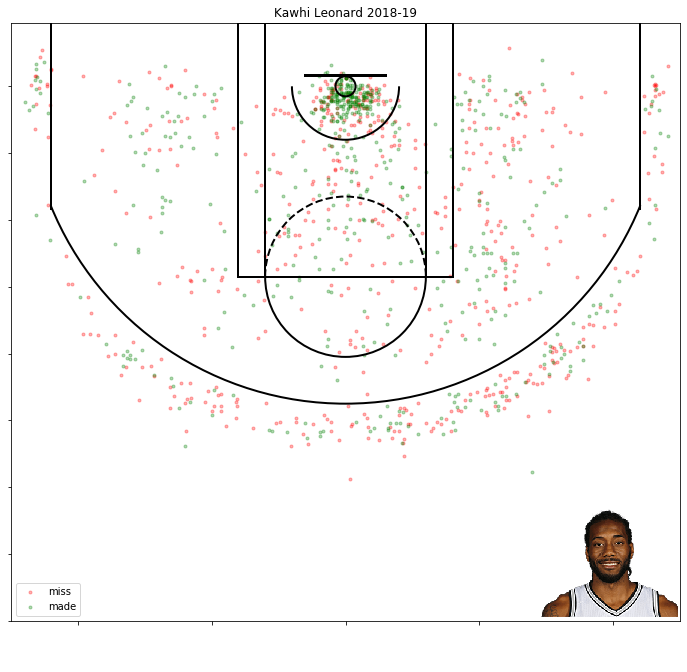

In [43]:
get_shot_chart(made,miss,game_stat_df,player_pic)

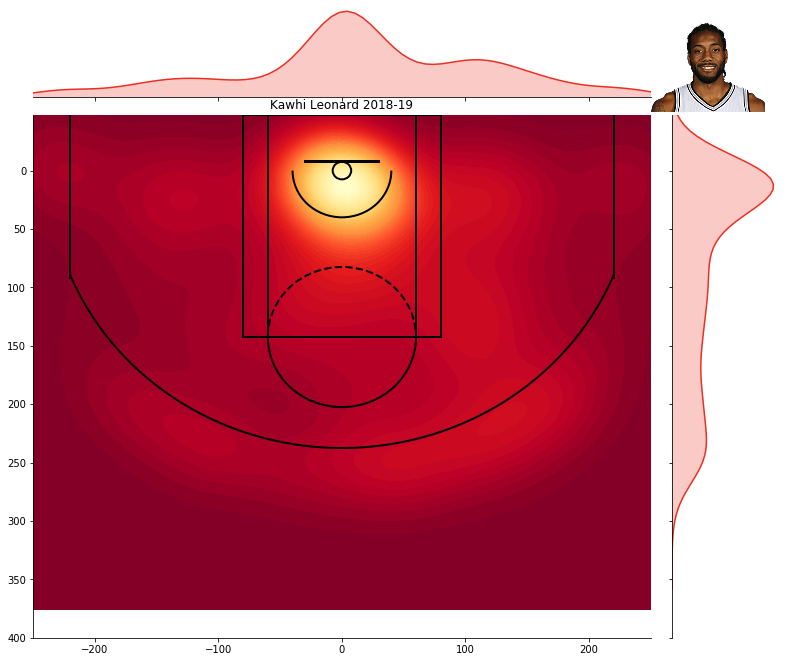

In [44]:
get_heat_map(game_stat_df,player_pic)

### Dirk Nowitzki 2018-19

In [64]:
player_id = input("please input the player's ID: ")
nba_season = input("please input the NBA season: ")

please input the player's ID: 1717
please input the NBA season: 2018-19


In [65]:
data = retrive_data(player_id,nba_season)
made,miss,game_stat_df = get_miss_and_made(data)
player_pic = get_pic(player_id)

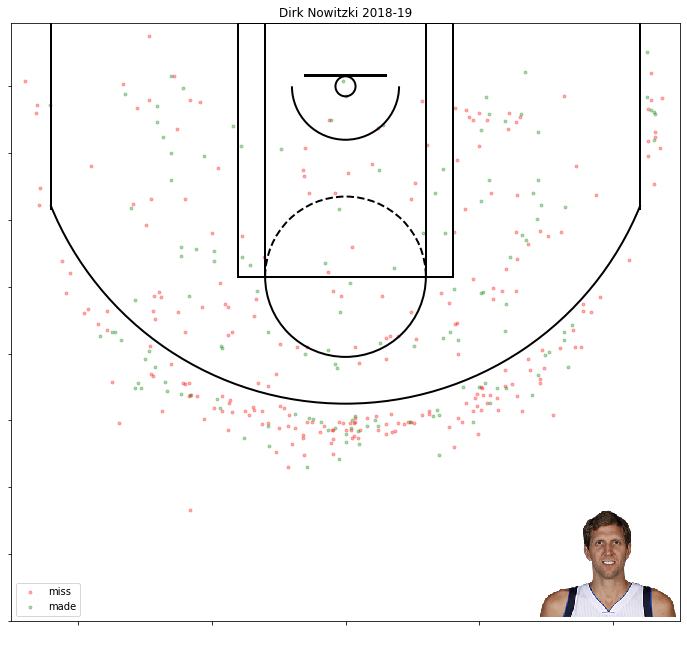

In [66]:
get_shot_chart(made,miss,game_stat_df,player_pic)

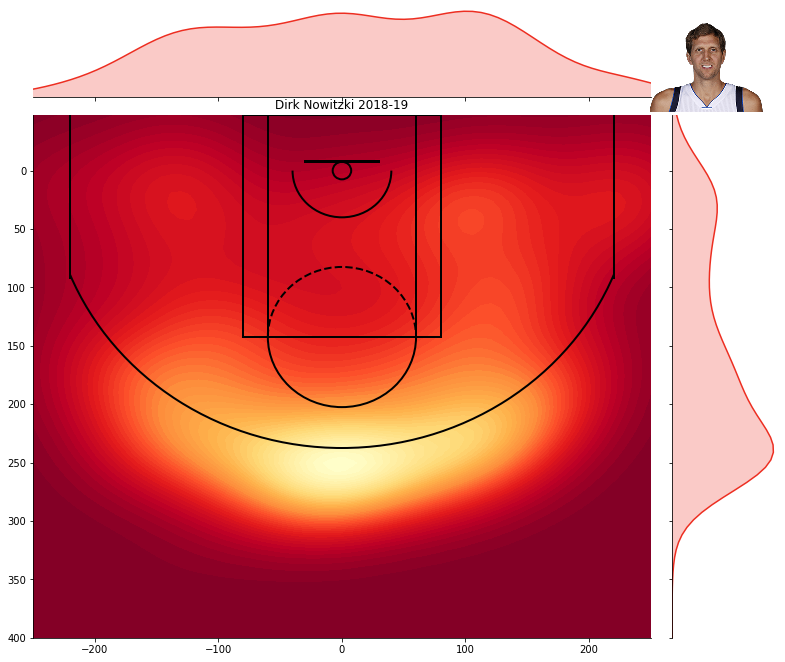

In [67]:
get_heat_map(game_stat_df,player_pic)

### Kobe Bryant All Time

In [115]:
def get_shot_chart_all_time(made,miss,game_stat_df,player_pic):
    plt.figure(figsize=(12,11))
    plt.ylim(400,-47.5)
    plt.xlim(-250,250)
    plt.scatter(miss.LOC_X,miss.LOC_Y,c='r',marker='.',alpha=0.3,label='miss')
    plt.scatter(made.LOC_X,made.LOC_Y,c='g',marker='.',alpha=0.3,label='made')
    plt.tick_params(labelbottom=False, labelleft=False)
    create_court()
    name = game_stat_df.iloc[0]['PLAYER_NAME']
    plt.title(name+' All Time')
    img = OffsetImage(player_pic, zoom=0.6)
    img.set_offset((540,55))
    plt.gca().add_artist(img)
    plt.legend()
    plt.show()

In [118]:
def get_heat_map_all_time(game_stat_df,player_pic):
    cmap=plt.cm.YlOrRd_r
    plot = sns.jointplot(x = game_stat_df.LOC_X,y=game_stat_df.LOC_Y,kind='kde',stat_func=None,color=cmap(0.3),cmap=cmap,n_levels =50)
    plot.fig.set_size_inches(12,10)
    ax = plot.ax_joint
    ax.set_ylim(400,-47.5)
    ax.set_xlim(-250,250)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')
    create_court(ax)
    name = game_stat_df.iloc[0]['PLAYER_NAME']
    ax.set_title(name+' All Time')
    img = OffsetImage(player_pic, zoom=0.5)
    img.set_offset((650,550))
    ax.add_artist(img)
    plt.show()

In [104]:
player_id = '977' 
nba_seasons = ['1996-97','1997-98','1998-99','1999-00','2000-01','2001-02','2002-03','2003-04','2004-05',
               '2005-06','2006-07','2007-08','2008-09','2009-10','2010-11','2011-12','2012-13','2013-14',
               '2014-15','2015-16']

In [114]:
player_pic = get_pic(player_id)
made_list = []
miss_list = []
game_stat_df_list = []
for season in nba_seasons:
    data = retrive_data(player_id,season)
    made,miss,game_stat_df = get_miss_and_made(data)
    made_list.append(made)
    miss_list.append(miss)
    game_stat_df_list.append(game_stat_df)
    print(season+' done')
merged_made_list = pd.concat(made_list)
merged_miss_list = pd.concat(miss_list)
merged_game_stat_df_list = pd.concat(game_stat_df_list)

1996-97 done
1997-98 done
1998-99 done
1999-00 done
2000-01 done
2001-02 done
2002-03 done
2003-04 done
2004-05 done
2005-06 done
2006-07 done
2007-08 done
2008-09 done
2009-10 done
2010-11 done
2011-12 done
2012-13 done
2013-14 done
2014-15 done
2015-16 done


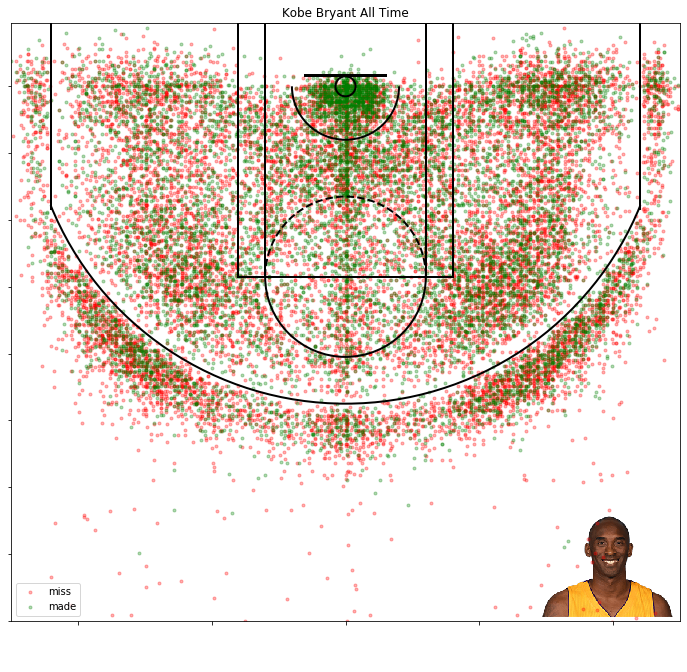

In [117]:
get_shot_chart_all_time(merged_made_list,merged_miss_list,merged_game_stat_df_list,player_pic)

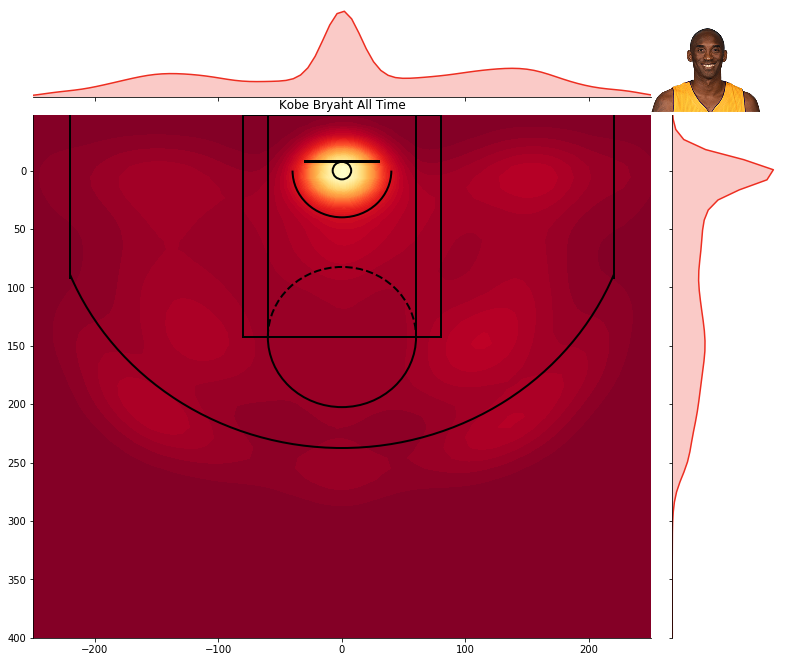

In [120]:
get_heat_map_all_time(merged_game_stat_df_list,player_pic)